# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix
import pyranges as pr
import subprocess
from Checkpoints import Checkpoint

# Call all datasets

In [ ]:
from common import *

dry = False

if dry == True:
    wgbs_bed_path = './test_data/mm39_ENCSR893RHD_modifications_mergeDups_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    oxbs_bed_path = './test_data/CRD018546.gz_val_1_bismark_bt2_pe.deduplicated.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, get_nanopore_threeMod(nano_3mod_path))

    nano_2mod_df = filterDepth(get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(get_bismark(oxbs_bed_path, "5mC"))

else:
    wgbs_bed_path = './data/WGBS_data/mm39_ENCSR893RHD_merged.bed'
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    oxbs_bed_path = './data/oxBS_data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed'

    nano_2mod_path = './data/Nanopore_binary_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/Nanopore_ternary_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, get_nanopore_threeMod(nano_3mod_path))

    nano_2mod_df = filterDepth(get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(get_bismark(oxbs_bed_path, "5mC"))

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
from Checkpoints import Checkpoint

if not "two_mod_wide" in locals():
    two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()
if not "mc_df_wide" in locals():
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
if not "hmc_df_wide" in locals():
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

In [ ]:
def subtractionMethod(wgbs, comp):
    merged = pd.merge(wgbs, comp, "inner", on=["chromosome", "chromStart", "chromEnd", "strand"])
    if comp.columns.__contains__("percentMeth_oxBS_5mC"):
        merged["percentMeth_subtraction_5hmC"] = merged["percentMeth_WGBS"].subtract(merged["percentMeth_oxBS_5mC"])
    elif comp.columns.__contains__("percentMeth_TAB_5hmC"):
        merged["percentMeth_subtraction_5mC"] = merged["percentMeth_WGBS"].subtract(merged["percentMeth_TAB_5hmC"])
    return merged

sub_hmc = subtractionMethod(two_mod_wide, mc_df_wide)
sub_mc = subtractionMethod(two_mod_wide, hmc_df_wide)
sub_hmc_compare = pd.merge(sub_hmc, hmc_df_wide, "inner", on=["chromosome", "chromStart", "chromEnd", "strand"])
sub_mc_compare = pd.merge(sub_mc, mc_df_wide, "inner", on=["chromosome", "chromStart", "chromEnd", "strand"])
sub_hmc_compare

In [ ]:
from scipy import stats
from graphing import linePlot

stats.pearsonr(sub_hmc_compare["percentMeth_subtraction_5hmC"], sub_hmc_compare["percentMeth_Nanopore_5hmC"])
fig, ax = plt.subplots()

sns.set_palette("tab10")

ax.plot(np.arange(0, 101, 1), "black", linestyle=":")
linePlot(sub_mc_compare, ax)
linePlot(sub_mc_compare, ax, True)

# Generating mlml-compatible datasets

In [2]:
from common import *
import pandas as pd

wgbs_bed_path = './data/WGBS_data/mm39_ENCSR893RHD_merged.bed'
wgbs_df = get_wgbs(wgbs_bed_path)

oxbs_bed_path = './data/oxBS_data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed' 
oxbs_df = get_bismark(oxbs_bed_path, "5mC")

tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
tab_df = get_bismark(tab_bed_path, "5hmC")

In [5]:
from common import filterDepth
import pandas as pd

def generateMLML(df, wgbs):
    df, wgbs = map(filterDepth, [df, wgbs])
    merged_df = pd.merge(df, wgbs, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_df", "_WGBS"])
    merged_df["percentMeth"] = merged_df["percentMeth_df"].divide(100)
    merged_df["context"] = "CPG"
    merged_df = merged_df[["chromosome", "chromStart", "strand", "context", "percentMeth", "readCount_df"]]
    return merged_df

In [20]:
# separate output for wgbs to match chrom and pos with oxBS

wgbs_data, oxbs_ref = map(filterDepth, [wgbs_df, oxbs_df])
wgbs_data = pd.merge(wgbs_data, oxbs_ref, "inner", on=["chromosome", "chromStart", "chromEnd"], suffixes=["_WGBS", "_oxBS"])
wgbs_data["percentMeth_alt"] = wgbs_data["percentMeth_WGBS"].divide(100)
wgbs_data["context"] = "CPG"

wgbs_data = wgbs_data[["chromosome", "chromStart", "strand", "context", "percentMeth_alt", "readCount_WGBS"]]
wgbs_data.to_csv("./DNMTools_datasets/mm39_ENCSR893RHD_merged_DNMToolsAlt_filtered.meth", sep="\t", header=None, index=False)

In [6]:
generateMLML(oxbs_df, wgbs_df).to_csv("./DNMTools_datasets/mm39_CRR008808_oxBS_DNMTools.meth", sep="\t", header=None, index=False)
generateMLML(tab_df, wgbs_df).to_csv("./DNMTools_datasets/mm39_CRR008807_TAB_DNMTools.meth", sep="\t", header=None, index=False)

# MLML comparison

In [4]:
import numpy as np 

three_mod_bis = pd.read_csv('./DNMTools_datasets/dnmtoolsMLML_output.txt', sep="\t", names=["chromosome", "chromStart", "chromEnd", "percentMeth_mC", "percentMeth_hmC", "percentMeth_C", "N_conflicts"])
three_mod_nano = pd.read_csv('./data/Nanopore_ternary_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed', sep="\t", 
                             names=["chromosome", "chromStart", "chromEnd", "modification_type", "score", "strand", "i0", "i1", "i2", "readCount_ALL", "percentMeth_mC", "N_C", "N_mC", "N_filt", "N_NA", "N_hmC"])

three_mod_nano["readCount"] = three_mod_nano["readCount_ALL"].subtract(
    np.add(three_mod_nano["N_filt"], three_mod_nano["N_NA"])
)

three_mod_nano = three_mod_nano.drop(columns=["modification_type", "score", "i0", "i1", "i2", "readCount_ALL", "N_filt", "N_NA"])

three_mod_nano["percentMeth_C"] = three_mod_nano["N_C"].divide(three_mod_nano["readCount"], axis=0)
three_mod_nano["percentMeth_hmC"] = three_mod_nano["N_hmC"].divide(three_mod_nano["readCount"], axis=0)
three_mod_nano["percentMeth_mC"] = three_mod_nano["N_mC"].divide(three_mod_nano["readCount"], axis=0)

three_mod_nano.replace(np.nan, 0)
three_mod_nano = three_mod_nano.loc[three_mod_nano["readCount"] >= 10]
three_mod_nano.drop(columns=["N_C", "N_mC", "N_hmC", "readCount"], inplace=True)

In [ ]:
merged_three_mod = pd.merge(three_mod_bis, three_mod_nano, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Bisulphite", "_Nanopore"])


In [ ]:
merged_three_mod = merged_three_mod[["chromosome", "chromStart", "chromEnd", "percentMeth_C_Bisulphite", "percentMeth_C_Nanopore", "percentMeth_mC_Bisulphite", "percentMeth_mC_Nanopore", "percentMeth_hmC_Bisulphite", "percentMeth_hmC_Nanopore", "strand"]]
merged_three_mod

,chromosome,chromStart,chromEnd,percentMeth_C_Bisulphite,percentMeth_C_Nanopore,percentMeth_mC_Bisulphite,percentMeth_mC_Nanopore,percentMeth_hmC_Bisulphite,percentMeth_hmC_Nanopore,strand
0,chr1,3070817,3070818,0.075949,0.000000,0.924051,0.869565,0.000000,0.000000,+
1,chr1,3070818,3070819,0.000000,0.047619,0.950000,0.904762,0.050000,0.000000,-
2,chr1,3070997,3070998,0.067515,0.157895,0.888044,0.631579,0.044441,0.052632,+
3,chr1,3070998,3070999,0.040000,0.062500,0.960000,0.750000,0.000000,0.062500,-
4,chr1,3071008,3071009,0.123457,0.157895,0.876543,0.736842,0.000000,0.052632,+
...,...,...,...,...,...,...,...,...,...,...
35919478,chrY,90756215,90756216,0.099197,0.114504,0.821103,0.480916,0.079700,0.091603,+
35919479,chrY,90756221,90756222,0.000000,0.084507,0.791667,0.464789,0.208333,0.098592,+
35919480,chrY,90756225,90756226,0.038902,0.054264,0.798754,0.573643,0.162344,0.062016,+
35919481,chrY,90756242,90756243,0.000000,0.083333,1.000000,0.568182,0.000000,0.037879,+


## ModDF

In [ ]:
import subprocess
from Checkpoints import Checkpoint

class ModDF:
    def __init__(self, dataframe):
        self.dataframe = dataframe


class ModFile:
    def __init__(self, path):
        self.path = path
        self.modtype = None

    def readFirstLine(self):
        return subprocess.check_output(["head", "-n 1", f"{self.path}"]).decode("utf-8").split("\t")
    
    def checkModType(self):
        """
        Determines the type of modification in the given modification file. If the modification isn't specified in the file itself, then the file path will be parsed for it. 
        """
        first_line = self.readFirstLine()

        if first_line[3] == "5mC":
            self.mod_type = "5mC"
        elif first_line[3] == "5hmC":
            self.mod_type = "5hmC"
        else: 
            if self.path is not None and self.path.__contains__("oxBS") or self.path.__contains("5mC"):
                self.mod_type = "5mC"
            elif self.path is not None and self.path.__contains__("TAB") or self.path.__contains("5hmC"):
                self.mod_type = "5hmC"
            else:
                raise ValueError("Modification type isn't clear from the file or filepath.")
        return print(f"mod_type is {self.mod_type}")
    
    def loadAsDataframe(self):
        """
        Load the specified path as a dataframe type object.
        """
        return ModDF(pd.read_csv(f'{self.path}', sep="\t", header=None))
        

In [ ]:
def mergeMethods(bis_df, nano_df):
    bis_df, nano_df = map(lambda df: df.drop(columns=["method", "modification_type"]), [bis_df, nano_df])

    if "strand" in bis_df.columns and "strand" in nano_df.columns:
        wide_merged = pd.merge(bis_df, nano_df, "inner", 
                               ["chromosome", "chromStart", "chromEnd", "strand"], 
                               suffixes=["_Bisulphite", "_Nanopore"])
    else: 
        wide_merged = pd.merge(bis_df, nano_df, "inner", 
                               ["chromosome", "chromStart", "chromEnd"], 
                               suffixes=["_Bisulphite", "_Nanopore"])
    
    long_merged = pd.wide_to_long(wide_merged, stubnames=["readCount", "percentMeth"], i=["chromosome", "chromStart", "chromEnd", "strand"], 
                                  j="method", sep="_", suffix="\D+").reset_index()
    
    wide_merged = wide_merged[["chromosome", "chromStart", "chromEnd", "strand", "readCount_Bisulphite", "percentMeth_TAB", "readCount_Nanopore", "percentMeth_Nanopore"]]
    long_merged = long_merged[["chromosome", "chromStart", "chromEnd", "method", "strand", "readCount", "percentMeth"]]

    return wide_merged.reset_index(drop=True), long_merged

In [ ]:
two_mod_wide, two_mod_long = mergeMethods(wgbs_df, nano_2mod_df)
mc_df_wide, mc_df_long  = mergeMethods(oxbs_df, nano_mc_df)
hmc_df_wide, hmc_df_long = mergeMethods(tab_df, nano_hmc_df)

## Bisulphite subtraction

In [ ]:
merged_wgbs_oxbs = pd.merge(wgbs_df, oxbs_df, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_WGBS", "_oxBS"])

In [ ]:
merged_wgbs_oxbs["percentMeth_Subtraction_5hmC"] = np.subtract(merged_wgbs_oxbs["percentMeth_WGBS"], merged_wgbs_oxbs["percentMeth_oxBS"])

In [ ]:
merged_wgbs_oxbs_wTAB = pd.merge(merged_wgbs_oxbs, tab_df, "inner", ["chromosome", "chromStart", "chromEnd"])

In [ ]:
merged_wgbs_oxbs_wTAB.loc[merged_wgbs_oxbs_wTAB["percentMeth_Subtraction_5hmC"] < 0, "percentMeth_Subtraction_5hmC"] = 0

In [ ]:
from scipy import stats

r = stats.pearsonr(merged_wgbs_oxbs_wTAB["percentMeth_Subtraction_5hmC"], merged_wgbs_oxbs_wTAB["percentMeth"])[0]

In [ ]:
merged_wgbs_oxbs_wTAB["bench_bin"] = pd.cut(merged_wgbs_oxbs_wTAB["percentMeth"], 51, labels=np.arange(0, 102, 2))

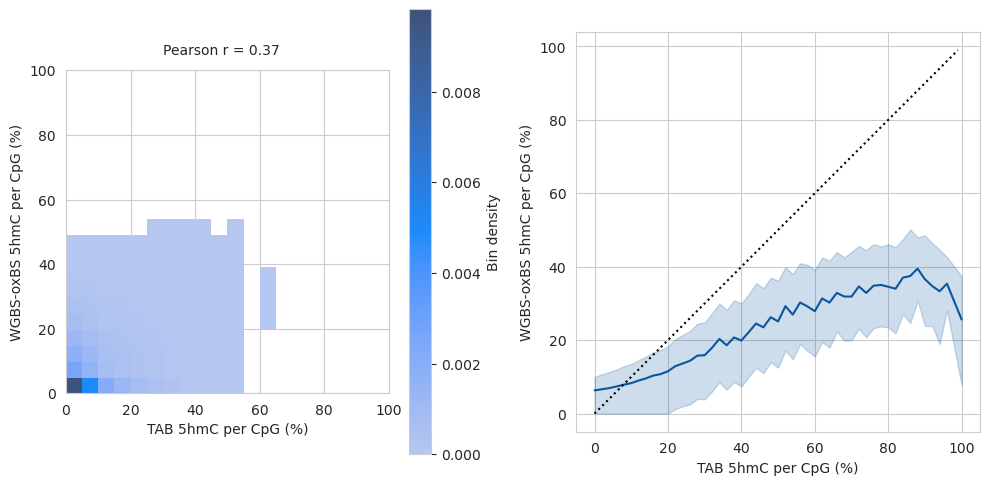

In [ ]:
from scipy import stats
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
# sns.set_palette("Blues_r")

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, fig)

ax = fig.add_subplot(gs[0, 0])

sns.histplot(merged_wgbs_oxbs_wTAB, x="percentMeth", y="percentMeth_Subtraction_5hmC", bins=20, pthresh=0.01, stat="density", cbar=True, cbar_kws={"label" : "Bin density"}, ax=ax)
ax.text(30, 105, "Pearson r = {r:.2f}".format(r=(r), ha="center"))
ax.set_xlim((0, 100))
ax.set_ylim((0, 100))
ax.set_ylabel("WGBS-oxBS 5hmC per CpG (%)")
ax.set_xlabel("TAB 5hmC per CpG (%)")
ax.set_aspect("equal")

ax2 = fig.add_subplot(gs[0, 1])
sns.lineplot(merged_wgbs_oxbs_wTAB, x="bench_bin", y="percentMeth_Subtraction_5hmC", errorbar=("pi", 50), ax=ax2)
ax2.plot(np.arange(0, 100), color="black", linestyle=":")
ax2.set_ylabel("WGBS-oxBS 5hmC per CpG (%)")
ax2.set_xlabel("TAB 5hmC per CpG (%)")
ax2.set_aspect("equal")

fig.tight_layout()


# Checkpointing system

I've used a checkpointing system to save computing time between function calls. This is implemented using a Class method to save processed dataframes as tab-separated (TSV) outputs, and load them again as required.  

# Locus level class definitions

## ConfusionMatrix

In [ ]:
mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def merge3Mod(): 
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

    mc_df_wide, hmc_df_wide = map(lambda df: df.drop(columns=["readCount_Bisulphite", "readCount_Nanopore"]), [mc_df_wide, hmc_df_wide])

    merged_df = pd.merge(mc_df_wide, hmc_df_wide, "inner", ["chromosome", "chromStart", "chromEnd", "strand"], suffixes=["_5mC", "_5hmC"])
    return merged_df
    
def defineTruthset():
    truth_list = np.select(
        [Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_TAB_5hmC"].gt(50), 
         Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_oxBS_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return truth_list

def definePredictions():
    prediction_list = np.select(
        [Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_Nanopore_5hmC"].gt(50), 
         Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_Nanopore_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return prediction_list
    
def binBenchmark(wide_df):
    wide_df["bin"] = pd.cut(wide_df["percentMeth_Bisulphite"], 51, labels=np.arange(0, 102, 2))
    return wide_df

def calcChiSquare(wide_df):
    x = pd.cut(wide_df["percentMeth_Bisulphite"], 21, labels=np.arange(0, 105, 5)).value_counts()
    y = pd.cut(wide_df["percentMeth_Nanopore"], 21, labels=np.arange(0, 105, 5)).value_counts()
    return stats.chisquare(x, y)

In [ ]:
Checkpoint(merge3Mod()).saveCheckpoint(name="three_state_comparison") 

In [ ]:
hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()
mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()

# Macro-scale 5hmC analysis

These figures compare 5hmC calling at the level of larger elements, including whole genes and 1kb windows. The focus of these images is on 5hmC - given that this is the modified base with lower apparent classification agreement (see above)

In [ ]:
def threeModDFtohmCPyrange():
    """
    Produces a PyRange object using only the 5hmC comparison data. 
    """
    data = Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint(
        colnames=["chromosome", "chromStart", "chromEnd", "strand", 
                  "percentMeth_Bisulphite_5mC", "percentMeth_Nanopore_5mC", 
                  "percentMeth_Bisulphite_5hmC", "percentMeth_Nanopore_5hmC"])
    pyrange = pr.from_dict({
        "Chromosome" : data["chromosome"],
        "Start" : data["chromStart"],
        "End" : data["chromEnd"],
        "Strand" : data["strand"],
        "percentMeth_Nanopore_5hmC" : data["percentMeth_Nanopore_5hmC"], 
        "percentMeth_Bisulphite_5hmC" : data["percentMeth_Bisulphite_5hmC"]
        }
        )
    return pyrange
    
Checkpoint(dataframe=threeModDFtohmCPyrange().as_df(), name="three_mod_pyrange").saveCheckpoint()

In [ ]:
from Checkpoints import Checkpoint

pyrange_data = Checkpoint(path='./intermediates/three_mod_pyrange.tsv').loadCheckpoint()

## Histograms with feature positions

In [ ]:
from FeatureReferences import Features
from Checkpoints import Checkpoint

repeats = Features('./feature_references/revised/repeats/UCSC_rmsk_mm39_Repeat.bed')
promoters = Features('./feature_references/revised/gene_features/name_adjusted/ENSEMBL_regFeatures_mm39_Promoter_wStrands.bed')

data = Checkpoint(path='./intermediates/three_mod_pyrange.tsv').loadCheckpoint()

In [ ]:
import pyranges as pr

repeats_data = pr.PyRanges(data).join(pr.PyRanges(repeats.dataframe)).as_df()
promoters_data = pr.PyRanges(data).join(pr.PyRanges(promoters.dataframe)).as_df()

Text(0, 0.5, 'Nanopore enrichment')

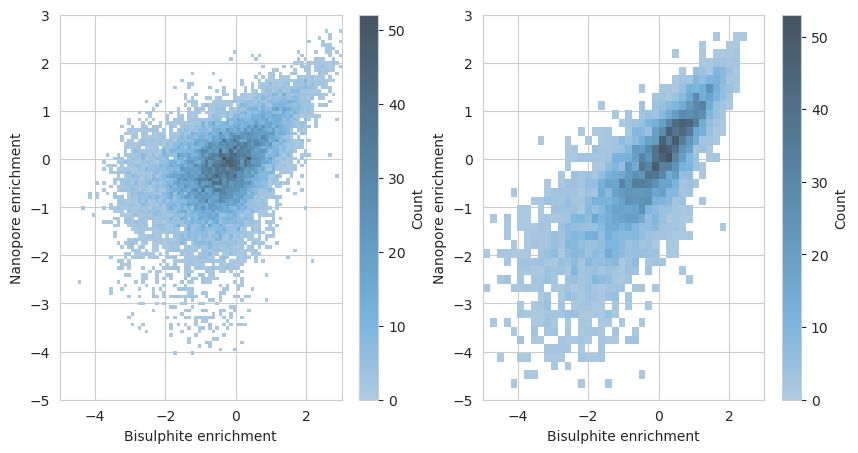

In [ ]:
from GroupCpGs import *
from CpGIntersects import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
sns.set_palette("Blues")

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, fig)

ax1 = fig.add_subplot(gs[0, 0])
FeatureAndGene(CpGIntersects(repeats_data).group("other"), 10).makeHist("count", ax1)
ax1.set_ylim((-5, 3))
ax1.set_xlim((-5, 3))
ax1.set_xlabel("Bisulphite enrichment")
ax1.set_ylabel("Nanopore enrichment")

ax2 = fig.add_subplot(gs[0, 1])
FeatureAndGene(CpGIntersects(promoters_data).group("other"), 10).makeHist("count", ax2)
ax2.set_ylim((-5, 3))
ax2.set_xlim((-5, 3))
ax2.set_xlabel("Bisulphite enrichment")
ax2.set_ylabel("Nanopore enrichment")

Text(0.5, 1.0, 'Repeats')

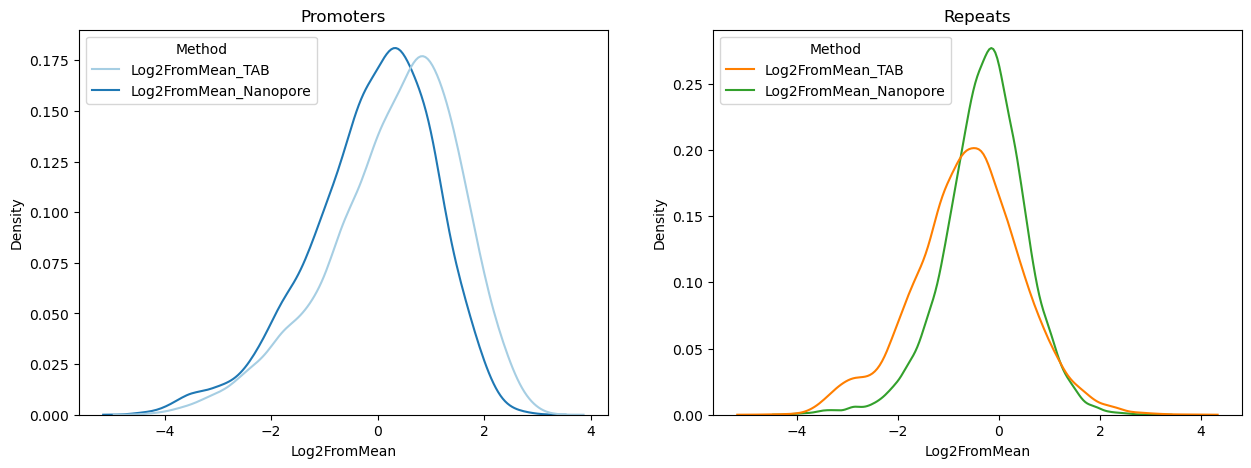

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from GroupCpGs import *

repeats_promoters = pd.concat([FeatureAndGene(CpGIntersects(repeats_data).group("other"), 10).df, 
                               FeatureAndGene(CpGIntersects(promoters_data).group("other"), 10).df])

repeats_promoters = FeatureAndGene(repeats_promoters, 10).dfWithLogCols()
repeats_promoters_melted = repeats_promoters.melt(["Name", "feature_type", "group_start", "group_end"], ["Log2FromMean_TAB", "Log2FromMean_Nanopore"], var_name="Method", value_name="Log2FromMean")

fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot2grid((1, 2), (0, 0), fig=fig)
sns.kdeplot(repeats_promoters_melted.loc[repeats_promoters_melted["feature_type"] == "Promoter"], x="Log2FromMean", hue="Method", palette="Paired", ax=ax1)
ax1.set_title("Promoters")

ax2 = plt.subplot2grid((1, 2), (0, 1), fig=fig)
sns.kdeplot(repeats_promoters_melted.loc[repeats_promoters_melted["feature_type"] == "Repeat"], x="Log2FromMean", hue="Method", palette="Paired_r", ax=ax2)
ax2.set_title("Repeats")


This would indicate that 5hmC is not consistent at each feature. Promoters appear to be more strongly hydroxymethylated (vs. mean) in TAB than Nanopore, and there is a greater tendency for repeat regions to be detected as _more hydroxymethylated_ relative to genomic mean hydroxymethylation in Nanopore than in TAB.

In [ ]:
import pyBigWig # required for bigWig output of pr 

def makeChromSizes():
    init = pd.read_csv('./feature_references/revised/mm39.chrom.sizes', sep="\t", names=["Chromosome", "End", "Start"])
    init["Start"] = 0
    init = init[["Chromosome", "Start", "End"]]
    return pr.PyRanges(init).sort()

In [ ]:
# three_mod_pr.to_bigwig('./outputs/nanopore_5hmC_chr1.bw', chromosome_sizes=makeChromSizes(), value_col="percentMeth_Nanopore_5hmC")

# Read level information at imprinted and non-imprinted sites

These scripts extract read level information from the modified bam files and perform clustering based on CpG site methylation states. The resulting clustermaps help to clearly show CpG sites with similar modification status. 

Of note, CpG sites are here aggregated (merged + and - strands) for ease of visualisation. 

In [ ]:
from modbampy import ModBam
import pandas as pd
import pyranges as pr
import numpy as np

In [ ]:
grb10_pr = pr.PyRanges(chromosomes="chr11", starts=[11878499], ends=[11989420], int64=True) # grb10 used here as an example (start/end coordinates based on mm39)
tiled_grb10_df = grb10_pr.tile(3000).as_df()
tiled_grb10_dict = tiled_grb10_df.to_dict("index")

In [ ]:
with ModBam('./data/prom_R10.4.1_E8.2_WGS_brain_DH_grb10.bam') as bam:
    tile_list = []
    tile_id = 1
    for tile in tiled_grb10_dict.values():
        read_list = []
        for read in bam.reads(tile["Chromosome"], tile["Start"], tile["End"]):
            read_sites = []
            for mod_position in read.mod_sites:
                mod_position_info = [tile_id, tile["Chromosome"], tile["Start"], tile["End"]]
                for datum in mod_position:
                    mod_position_info.append(datum)
                read_sites.append(mod_position_info)
            read_list.extend(read_sites)
        tile_list.extend(read_list)
        tile_id += 1 
names=["tile", "chromosome", "chromStart", "chromEnd", "read", "refPos", "qPos", "refStrand", "modStrand", "base", "mod", "score"]
tile_df = pd.DataFrame(tile_list, columns=names)
    
def filterTile(tile): 
    # tile_df.loc[tile_df["refStrand"] == "-", "refPos"] = tile_df["refPos"].sub(2, axis=0)
    one_tile_df = tile_df.loc[(tile_df["tile"] == tile) & (tile_df["refPos"].ge(tile_df["chromStart"])) & (tile_df["refPos"].lt(tile_df["chromEnd"]))] 
    
    tile_df_pivot1 = one_tile_df.pivot(index=["tile", "chromosome", "chromStart", "chromEnd", "refStrand", "read", "refPos", "qPos"], columns="mod", values="score").reset_index()
    tile_df_pivot1["c"] = 255 - tile_df_pivot1[["h", "m"]].sum(axis=1)
    tile_df_melt = pd.melt(tile_df_pivot1, ["tile", "chromosome", "chromStart", "chromEnd", "refStrand", "read", "refPos", "qPos"], ["h", "m", "c"], "mod", "score")
    tile_df_melt = tile_df_melt.loc[tile_df_melt["score"] >= 0.66*255]
    tile_df_melt.loc[tile_df_melt["refStrand"] == "-", "refPos"] = tile_df_melt["refPos"].sub(1, axis=0)

    return tile_df_melt.reset_index(drop=True)

def pivotToHeatmap(df):
    df = df.pivot(index="read", columns=["refPos"], values="mod")
    df[df == "c"] = 0
    df[df == "h"] = 2
    df[df == "m"] = 1
    
    return df

def NADropper(df):
    new_df = df.dropna(thresh=len(df)*0.2, axis="columns") # removes CpGs present in fewer than 20% of reads
    new_df = new_df.dropna(thresh=len(new_df.columns)*0.50, axis="index") # removes reads with fewer than x% of CpGs
    return new_df

def makeHeatmap(tile):

    data = NADropper(pivotToHeatmap(filterTile(tile)))

    fig = sns.clustermap(data.fillna(-1), 
                mask=data.isna(), 
                xticklabels=10, yticklabels=False,
                col_cluster=False, row_cluster=True, 
                cmap=sns.color_palette("Blues", 3),
                cbar_kws={"ticks" : [0, 1, 2],
                        "orientation" : "horizontal"},
                figsize=(10, 10))

    fig.ax_cbar.set_position([0.40, 0.85, 0.3, 0.03])
    fig.ax_cbar.set_xticks([0.33, 1, 1.66])
    fig.ax_cbar.set_xticklabels(["C", "5mC", "5hmC"])
    fig.ax_cbar.set_title("Modification type", fontdict={"fontsize" : 10})
    fig.ax_heatmap.set_ylabel("Read")
    fig.ax_heatmap.set_xlabel("CpG position")

    return fig

In [ ]:
import numpy as np

def makeTileHeatmaps():
    for tile in np.arange(1, 39, 1):
        fig = makeHeatmap(tile)
        fig.savefig(f'./outputs/Grb10_heatmaps/tile_{tile}_heatmap.png', dpi=600)
        plt.close(fig)
    return 

makeTileHeatmaps()

NameError: name 'makeHeatmap' is not defined

## Stat functions